{"username":"aruiz0","key":"4f80abda3b26bce49f72c77b3cee9878"}
archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_270deg.JPG


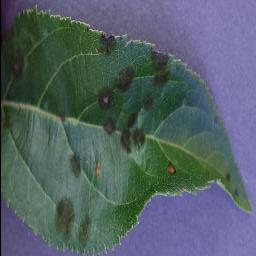

In [1]:
############################## LOAD IN DATA AND TEST BY SHOWING IMAGE
# open json 
f = open("kaggle.json", "r")
print(f.read())

##############################
# opendatasets and download
import opendatasets as ods

if 0: # only has to be ran if no dataset
    ods.download('https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset')
#else:
#    ods = 'Downloads/ar-alexnet/new-plant-diseases-dataset'

##############################
## open an image to check if dataset was downloaded
from IPython.display import Image
dataroot = 'archive/New Plant Diseases Dataset(Augmented)'
img = dataroot + '/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_270deg.JPG'
print(img)
Image(img)

In [2]:
############################## IMPORT PACKAGES
#!pip install tensorflow

import PIL
import scipy
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import Model, callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D,
                                     Input)
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Convolution2D,Activation,Flatten,Dense,Dropout,MaxPool2D,BatchNormalization

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 


In [3]:
############################## TRAINING PARAMS
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
    print('using gpu')

print("Number of accelerators: ", strategy.num_replicas_in_sync)

##############################
data_dir = dataroot + '/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + "/train"
test_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print("Total disease classes are: {}".format(len(diseases)))

train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode="nearest",
                                   rotation_range = 20,
                                   width_shift_range=0.2,
                                    height_shift_range=0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2) # set validation split


test_datagen_aug = ImageDataGenerator( rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   horizontal_flip = True)


training_set_aug = train_datagen_aug.flow_from_directory(directory= train_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical',
                                               subset='training')


validation_set_aug = train_datagen_aug.flow_from_directory(directory= train_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical',
                                               subset='validation',
                                               shuffle=False)



label_map = (training_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)
label_map = (validation_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)

print(test_dir)

test_set_aug = test_datagen_aug.flow_from_directory(directory= test_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical') # for 2 class binary

label_map = (test_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
using gpu
Number of accelerators:  1
Total disease classes are: 38
Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.
Target Classes Mapping Dict:

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Po

In [4]:
################# [2] CREATE MODEL

with strategy.scope():
    # Instantiate an empty sequential model
    model = Sequential(name="Alexnet")
    # 1st layer (conv + pool + batchnorm)
    model.add(Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', kernel_regularizer=l2(0.0005), input_shape = (224,224,3)))
    model.add(Activation('relu'))  #<---- activation function can be added on its own layer or within the Conv2D function
    model.add(MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
    model.add(BatchNormalization())

    # 2nd layer (conv + pool + batchnorm)
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    # layer 3 (conv + batchnorm)      <--- note that the authors did not add a POOL layer here
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # layer 4 (conv + batchnorm)      <--- similar to layer 3
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # layer 5 (conv + batchnorm)
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # Flatten the CNN output to feed it with fully connected layers
    model.add(Flatten())

    # layer 6 (Dense layer + dropout)
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.5))

    # layer 7 (Dense layers)
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.5))

    # layer 8 (softmax output layer)
    model.add(Dense(units = 38, activation = 'softmax'))

    print(model.summary())

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy',TopKCategoricalAccuracy(k=1, name="top1")])




Model: "Alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 26, 26, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 26, 26, 256)       0 

In [5]:
########################### TRAIN MODEL AND SAVE

early_stopping_cb = callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                              factor=0.2,
                                              patience=2,
                                              verbose=1,
                                              min_lr=1e-7)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_loss")

history = model.fit(training_set_aug,
                    epochs=20,  # initially 20
                    verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint, reduce_lr],
                    validation_data = validation_set_aug,
                    #steps_per_epoch = 100, # initially commented
                    #validation_steps = 100 # initially commented
                    )

filepath="AlexNetModel_test0.keras"
model.save(filepath)

Epoch 1/20


440/440 [==============================] - 1055s 2s/step - loss: 3.5864 - accuracy: 0.3126 - top_k_categorical_accuracy: 0.6672 - top1: 0.3126 - val_loss: 2.4672 - val_accuracy: 0.3997 - val_top_k_categorical_accuracy: 0.7983 - val_top1: 0.3997 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - 1041s 2s/step - loss: 1.9215 - accuracy: 0.5687 - top_k_categorical_accuracy: 0.8927 - top1: 0.5687 - val_loss: 3.3365 - val_accuracy: 0.2728 - val_top_k_categorical_accuracy: 0.6351 - val_top1: 0.2728 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - 1040s 2s/step - loss: 1.4953 - accuracy: 0.6704 - top_k_categorical_accuracy: 0.9397 - top1: 0.6704 - val_loss: 1.3625 - val_accuracy: 0.6817 - val_top_k_categorical_accuracy: 0.9512 - val_top1: 0.6817 - lr: 0.0010
Epoch 4/20
440/440 [==============================] - 1052s 2s/step - loss: 1.2727 - accuracy: 0.7264 - top_k_categorical_accuracy: 0.9595 - top1: 0.7264 - val_loss: 1.9980 - val_accuracy: 0.

In [6]:
########################### TEST MODEL

model.load_weights(checkpoint_path)
model.evaluate(test_set_aug)


138/138 [==============================] - 175s 1s/step - loss: 0.2022 - accuracy: 0.9778 - top_k_categorical_accuracy: 0.9997 - top1: 0.9778


[0.20219087600708008,
 0.9778056144714355,
 0.9996585249900818,
 0.9778056144714355]

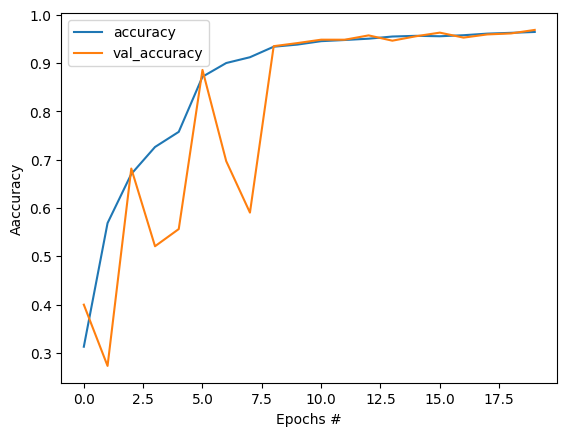

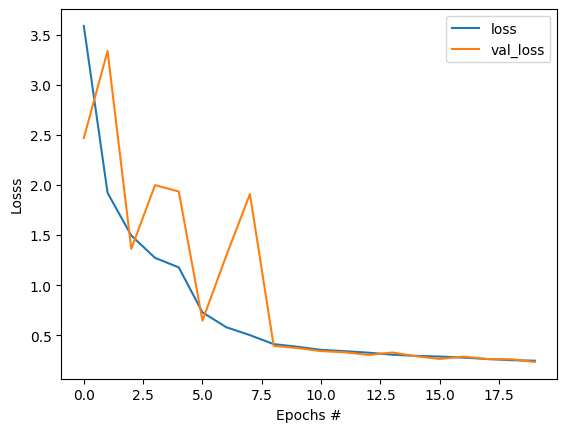

110/110 [==============================] - 135s 1s/step


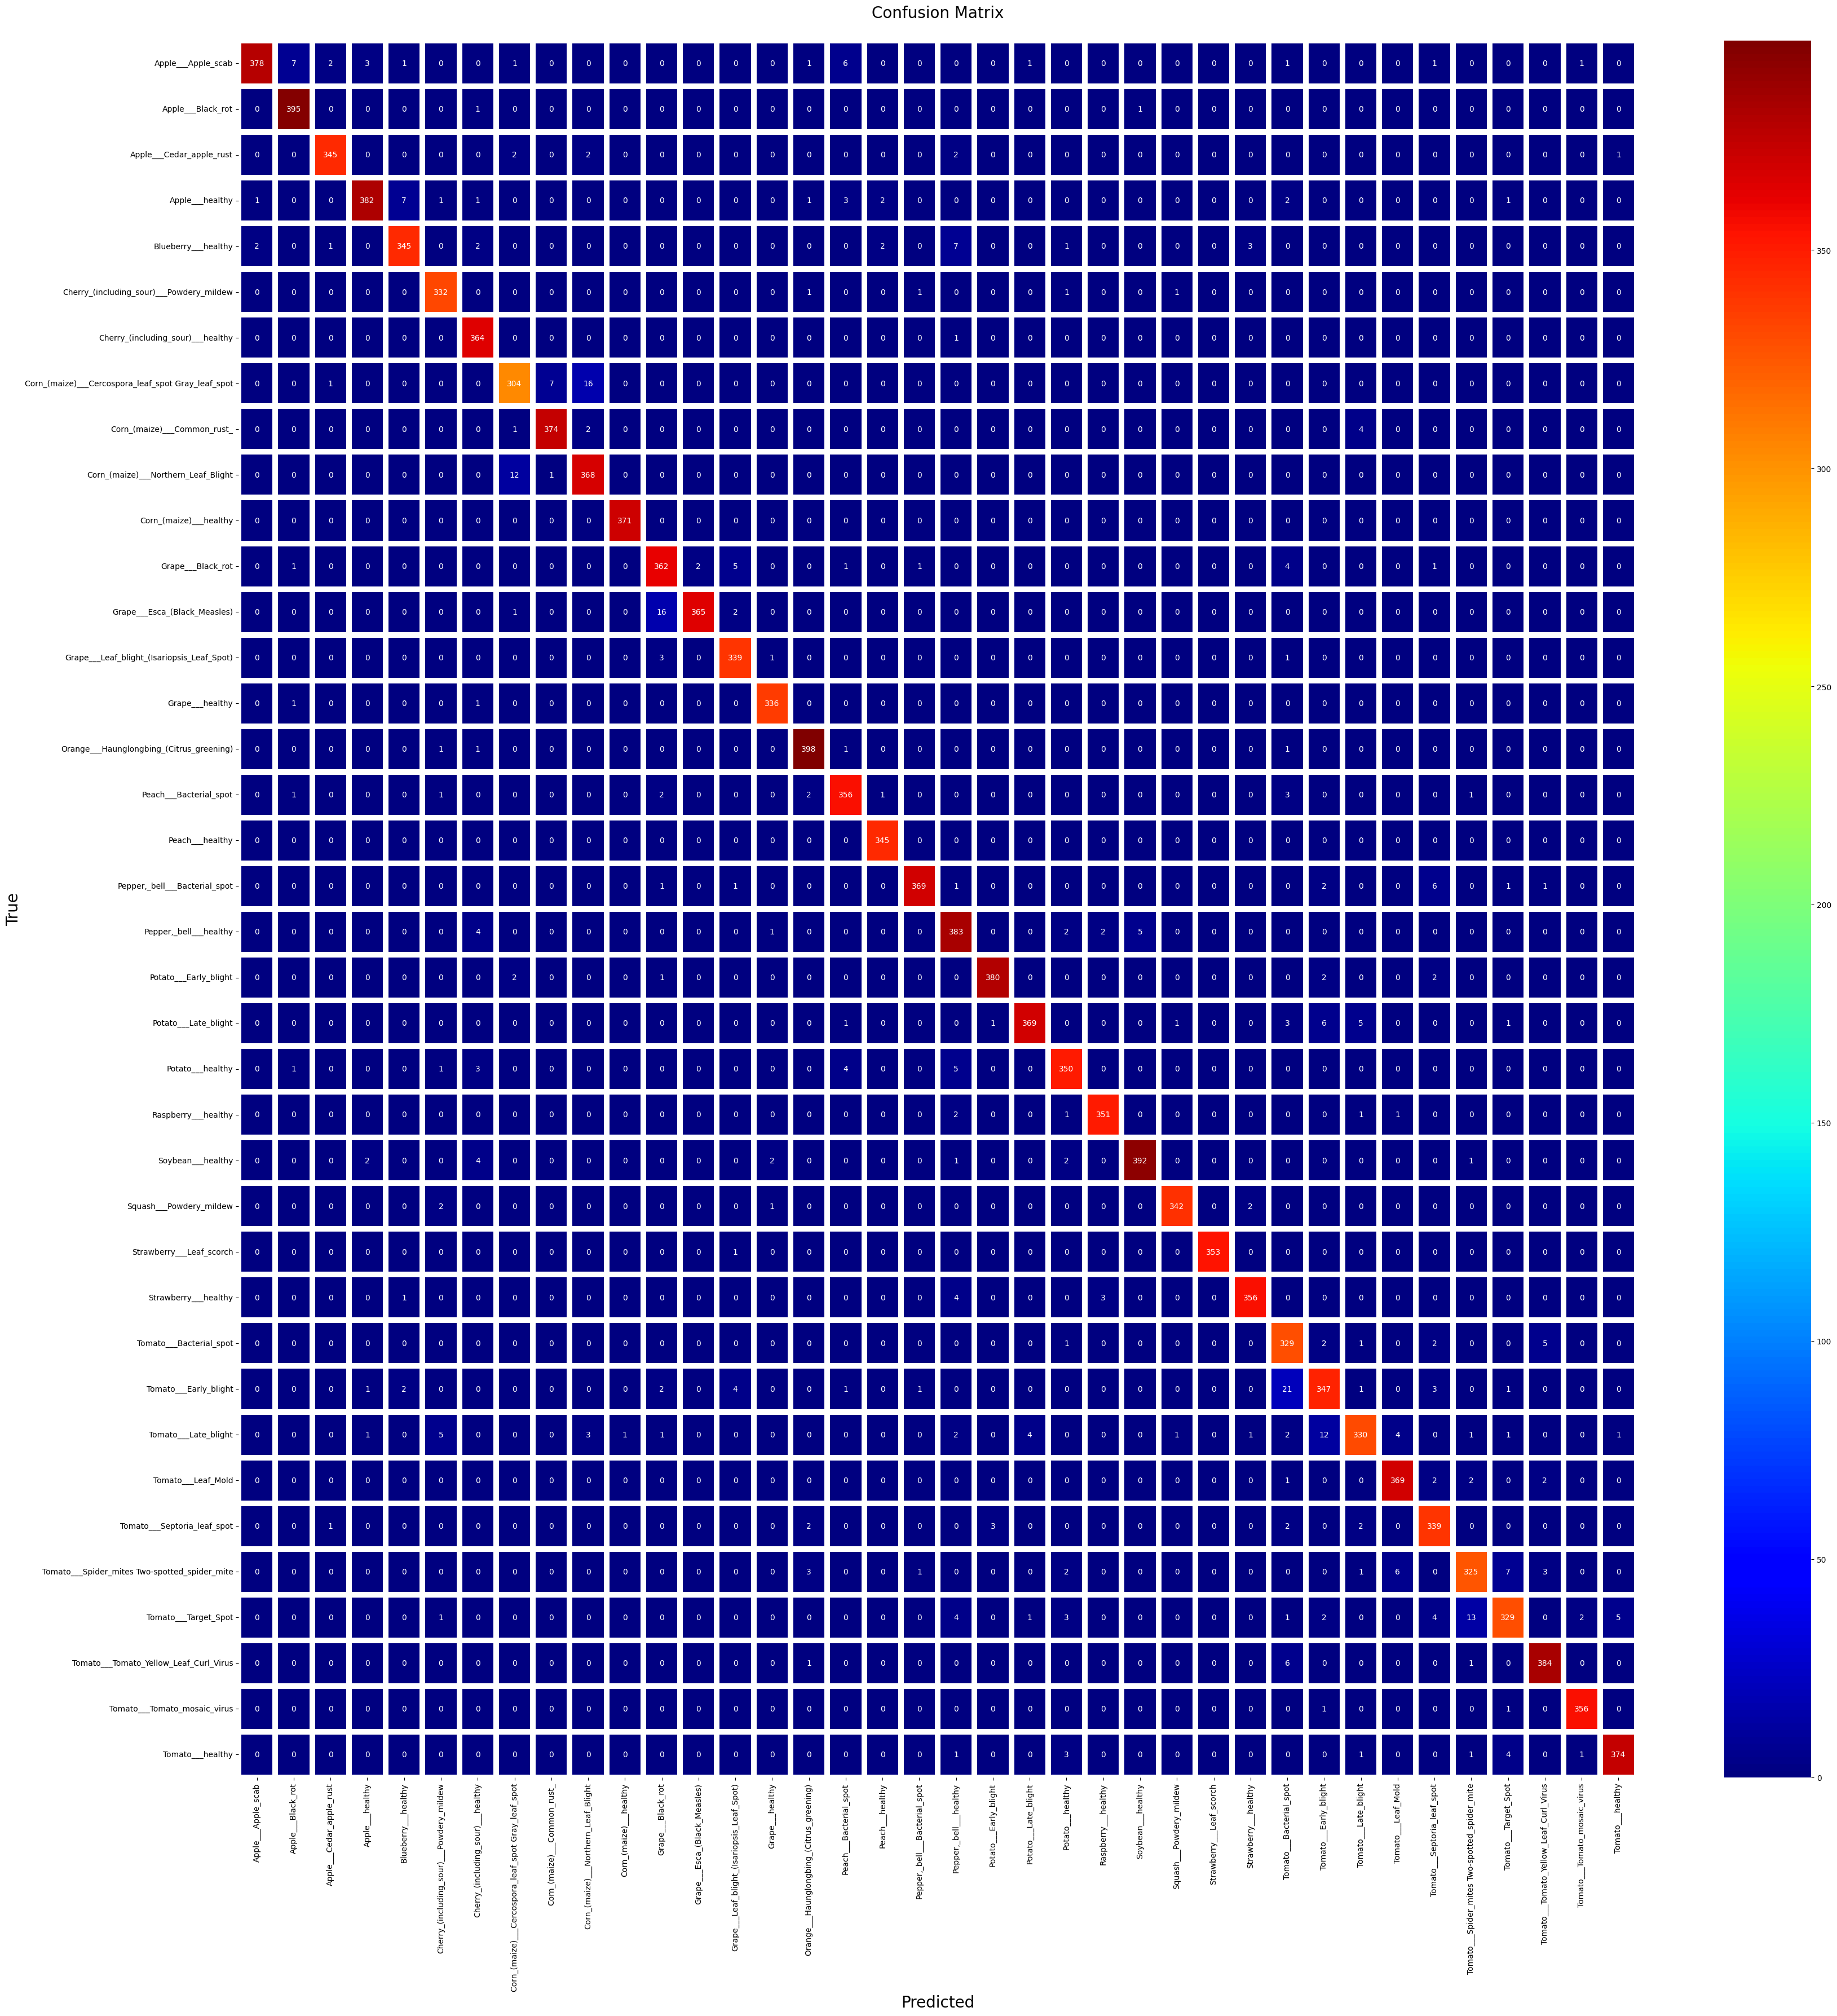

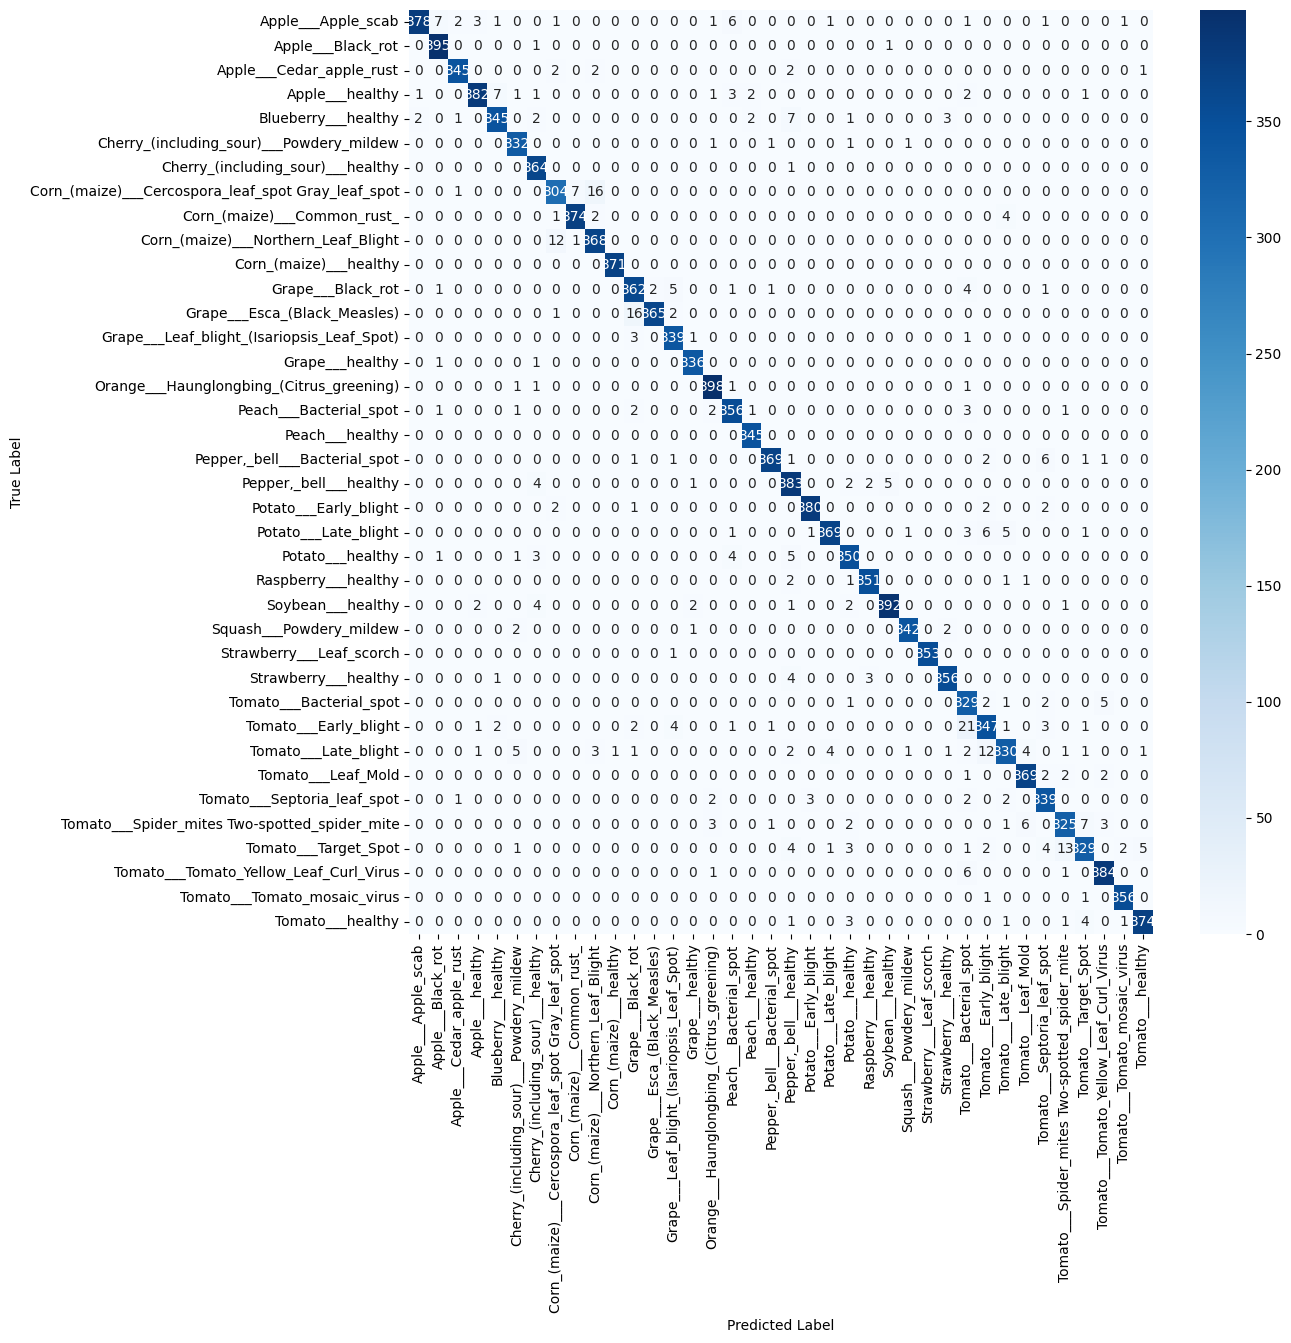

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.94      0.96       403
                                 Apple___Black_rot       0.97      0.99      0.98       397
                          Apple___Cedar_apple_rust       0.99      0.98      0.98       352
                                   Apple___healthy       0.98      0.95      0.97       401
                               Blueberry___healthy       0.97      0.95      0.96       363
          Cherry_(including_sour)___Powdery_mildew       0.97      0.99      0.98       336
                 Cherry_(including_sour)___healthy       0.96      1.00      0.98       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.93      0.93       328
                       Corn_(maize)___Common_rust_       0.98      0.98      0.98       381
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.97      0.

In [13]:
########################### PLOTTING

########################### ACCURACIES
hist = history.history
def show_plt(type):
    if type == 1:
        plt.plot(hist["accuracy"], label="accuracy")
        plt.plot(hist["val_accuracy"], label="val_accuracy")
        plt.ylabel("Aaccuracy")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
    else:
        plt.plot(hist["loss"], label="loss")
        plt.plot(hist["val_loss"], label="val_loss")
        plt.ylabel("Losss")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
        
show_plt(1)
show_plt(0)



########################### CONFUSION MATRIX
# reset the test_data to start iterating over dataset from scratch
validation_set_aug.reset()
# start to predict
pred = model.predict(validation_set_aug)

final_predict = np.argmax(pred,axis=1)
true_data=validation_set_aug.classes

plt.figure(figsize=(40,40))
confusion = confusion_matrix(true_data, final_predict)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=label_map,
            yticklabels=label_map,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()

# Create a confusion matrix
conf_matrix = confusion_matrix(true_data, final_predict)
# Display the confusion matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=label_map, yticklabels=label_map)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

########################### CLASSIFICATION REPORT
from sklearn.metrics import classification_report 
print(classification_report(true_data, final_predict,target_names=label_map))

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(true_data,final_predict)
print(f'Accuracy Score: {acc_score:.4f}')

class_dict = training_set_aug.class_indices
print(class_dict)

li = list(class_dict.keys())
print(li)


Following is our prediction:
1/1 [==============================] - 0s 193ms/step


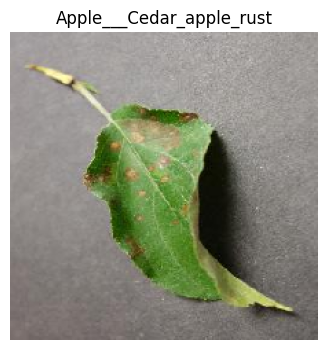

In [8]:
############################ TEST PREDICTING IMAGE
from tensorflow.keras.preprocessing import image
import numpy as np
image_path = "archive/test/test/AppleCedarRust3.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
#img_class = classifier.predict_classes(img)
#img_prob = classifier.predict_proba(img)
#print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()